# Project: Investigate a dataset (Main Cancers Deaths in Men) 

### Table of Contents  

- <a href = "#intro">Introduction </a>  
- <a href = "#wrangling">Data Wrangling </a> 
- <a href = "#">Exploratory Data Analysis </a>  
- <a href = "#">Conclusions </a>   


# Introduction






In [1]:
# Import all the needed packages for the project
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline 

<h2 id = wrangling>Data Wrangling </h2>  
First of all we have to import all the separated files and gather it in one unique dataset.  
Let us start with the importation.

### General Properties

In [3]:
## Load all the files 
liver_df = pd.read_csv("files/liver_cancer_number_of_male_deaths.csv")
lung_df = pd.read_csv("files/lung_cancer_number_of_male_deaths.csv")
prostate_df = pd.read_csv("files/prostate_cancer_number_of_male_deaths.csv")
stomach_df = pd.read_csv("files/stomach_cancer_number_of_male_deaths.csv")

# Check thr structure of the files
liver_df.head(1)  
lung_df.head(1)
prostate_df.head(1)
stomach_df.head(1)


,country,1990,1991,1992,1993,1994,1995,1996,1997,1998,...,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016
0,Afghanistan,482.0,519.0,568.0,630.0,698.0,758.0,797.0,826.0,850.0,...,1180.0,1200.0,1210.0,1230.0,1250.0,1280.0,1310.0,1350.0,1400.0,1450.0


In [10]:
# Transform the files from wide to long
def gather(df,value_name:str) -> "df": # Define the function gather that will return a dataframe
    """function to transform and rename the columns """
    # Transform and rename in a row with melt and rename methods 
    df = df.melt(id_vars = ["country"],var_name = "year", value_name = value_name) 
    return df

# Use the gather function to transform each file 
liver_long = gather(liver_df, "liver_deaths")          # Transform liver_df
lung_long = gather(lung_df, "lung_deaths")             # Transform lung_df
stomach_long = gather(stomach_df, "stomach_deaths")    # Transform stomach_df
prostate_long = gather(prostate_df, "prostate_deaths") # transform prostate_df
liver_long.head()

,country,year,liver_deaths
0,Afghanistan,1990,124.00
1,Albania,1990,149.00
2,Algeria,1990,215.00
3,Andorra,1990,1.25
4,Angola,1990,302.00


In [11]:
# Check the files to see if all is correct 
prostate_long.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049 entries, 0 to 5048
Data columns (total 3 columns):
country            5049 non-null object
year               5049 non-null object
prostate_deaths    5049 non-null float64
dtypes: float64(1), object(2)
memory usage: 118.4+ KB


Now that our file are ok, let put it all together in one unique dataframe

In [12]:
cancers_df = liver_long  # Create a new dataframe with all the values of liver_long dataframe 
cancers_df["lung_deaths"] = lung_long.lung_deaths  # Add the new column lung_deaths with its value from lung_long df
cancers_df["stomach_deaths"] = stomach_long.stomach_deaths    # Add the new column stomach_deaths with its values from stomach_long df 
cancers_df["prostate_deaths"] = prostate_long.prostate_deaths #Add the new column prostate_deaths with its values from prostate_long df 
cancers_df.head()  # Check the first few rows

,country,year,liver_deaths,lung_deaths,stomach_deaths,prostate_deaths
0,Afghanistan,1990,124.00,577.0,482.00,130.00
1,Albania,1990,149.00,471.0,207.00,149.00
2,Algeria,1990,215.00,1150.0,650.00,261.00
3,Andorra,1990,1.25,13.7,4.02,7.16
4,Angola,1990,302.00,268.0,283.00,233.00


In [13]:
# Check the info of the finale data 
cancers_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5049 entries, 0 to 5048
Data columns (total 6 columns):
country            5049 non-null object
year               5049 non-null object
liver_deaths       5049 non-null float64
lung_deaths        5049 non-null float64
stomach_deaths     5049 non-null float64
prostate_deaths    5049 non-null float64
dtypes: float64(4), object(2)
memory usage: 236.8+ KB


Checking the info of the final dataframe, we can see that there are no missing values, the data types are correct
we have a clean data. Let's see some statistic to have an overview


In [14]:
cancers_df.describe()

,liver_deaths,lung_deaths,stomach_deaths,prostate_deaths
count,5049.000000,5049.000000,5049.000000,5049.000000
mean,2413.228984,5105.906282,2724.360368,1470.019778
std,19456.176523,24621.169653,17347.627108,3670.981779
min,0.610000,2.260000,1.150000,0.820000
25%,46.100000,94.900000,56.600000,69.500000
50%,205.000000,434.000000,331.000000,308.000000
75%,687.000000,2140.000000,999.000000,1170.000000
max,324000.000000,424000.000000,257000.000000,35500.000000


We see that in general there are more deaths of lung cancer, actually we have an average of **5106** deaths over years and a maximum of **424000** deaths which is almost the double of the stomach deaths(**257000**) over years. let's make a little plot to visualize it.

AttributeError: Unknown property king

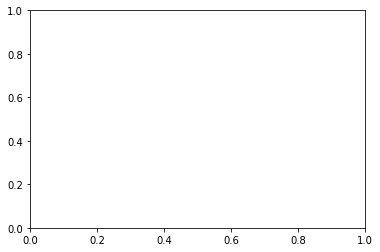